## Adiabatic quantum computing

Suppose we need to find the ground state of a Hamiltonian $H_1$ that we can prepare. To do that, we first prepare the Hamiltonian $H_0$, then slowly change it into the target Hamitlonian. Adiabatic theorem states that under these conditions the system remains in the ground state.

In [1]:
import numpy as np
import scipy.linalg as SPLA
from scipy.integrate import solve_ivp
from functools import reduce
import matplotlib.pyplot as plt
from collections import deque

### Define the initial and target Hamiltonians

In [2]:
X = np.array([[0, 1], [1, 0]], dtype=np.complex64)
Y = np.array([[0, -1j], [1j, 0]])
Z = np.diag([1, -1])
I = np.eye(2)

#### Ising model

In [3]:
def ising_model(n_spins, J, hx):
    '''Ising model with transverse field'''
    ham = {}
    line = 'Z' + 'Z' + 'I' * (n_spins - 2)
    for i in range(n_spins):
        term = line[-i:] + line[:-i]
        ham[term] = J
    line = 'X' + 'I' * (n_spins - 1)
    if hx != 0:
        for i in range(n_spins):
            term = line[-i:] + line[:-i]
            ham[term] = hx
    return ham

def explicit_hamiltonian(ham_dict):
    n_qubits = len(list(ham_dict.keys())[0])
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.diag([1, -1])
    pauli={}
    pauli['I'] = I
    pauli['X'] = X
    pauli['Y'] = Y
    pauli['Z'] = Z
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype='complex128')
    for term, energy in ham_dict.items():
        matrices=[]
        for sym in term:
            matrices.append(pauli[sym])
        total_mat = energy * reduce(np.kron, matrices)
        H +=total_mat
    return H

#### SAT embedding

In [4]:
def random_clause(num_variables, k=3):
    '''Generate a random clause for k-SAT. Returns a list of three
    integers
    '''
    clause = np.random.choice(num_variables, k, replace=False) + 1
    clause = [c * ((-1)**np.random.randint(2)) for c in clause]
    return clause

def random_SAT_instance(num_variables, num_clauses, k=3):
    '''
    Generate a random instance of K-SAT
    '''
    return [random_clause(num_variables, k) for i in range(num_clauses)]

def make_SAT_Hamiltonian(sat_instance, num_bits, pauli=Z):
    '''Creates a Hamiltonian from a SAT instance. pauli specifies which
    basis to use
    '''    
    H = np.zeros((2**num_bits, 2**num_bits))
    for clause in sat_instance:
        term_list = [I] * num_bits
        for i in clause:
            term_list[abs(i) - 1] = 0.5 * (I + pauli * np.sign(i))
        H += reduce(np.kron, term_list)
    return H

#### Putting it together and defining the initial state

In [5]:
n_qubits = 6

ham_term = deque([X] + [I] * (n_qubits - 1))

H_0 = np.zeros((2**n_qubits, 2**n_qubits), dtype=np.complex64)

for i in range(n_qubits):
    H_0 += (-0.5) * reduce(np.kron, ham_term)
    ham_term.rotate(1)


#H_1_dict = ising_model(n_qubits, 1, -0.1)
#H_1 = explicit_hamiltonian(H_1_dict)

sat_instance = random_SAT_instance(n_qubits, round(n_qubits * 5))
H_1 = make_SAT_Hamiltonian(sat_instance, n_qubits)

In [6]:
# Initial state is a Kronecker product of |+> = 1/ sqrt(2) * (|0> + |1>)
total_plus_state = np.ones(2**n_qubits, dtype=np.complex64) / (2**n_qubits)**0.5

### Define the system of differential equations

In [7]:
def s_linear(t, alpha):
    '''Adiabatic evolution strategy'''
    if t < 0:
        raise ValueError('Enter positive t')
    elif t > 1 / alpha:
        return 1
    else:
        return t * alpha      
    
def get_state_energy(s, t, y):
    H = H_total(H_0, H_1, s(t))
    return y.conj() @ H @ y

def H_total(H_0, H_1, s_curr):
    return (1 - s_curr) * H_0 + s_curr * H_1

def make_f(H_0, H_1, s):
    '''Create a system of differential equations'''
    def f(t, y):
        H = (1 - s(t)) * H_0 + s(t) * H_1
        #H = H_total(H_0, H_1, s(t))
        return -1j * H @ y
    return f

In [8]:
alpha = 0.1


def s(t):
    '''Simple strategy of changing the Hamiltonian'''
    return s_linear(t, alpha)

f = make_f(H_0, H_1, s)

### Run the solver

In [9]:
sol = solve_ivp(f, [0, 1 / alpha], total_plus_state, max_step=0.2)

In [10]:
exact_energies = []
energies = []
for i, t in enumerate(sol.t):
    energies.append(get_state_energy(s, t, sol.y[:, i]).real)
    H = H_total(H_0, H_1, s(t))
    w, v = np.linalg.eigh(H)
    exact_energies.append(w[0])

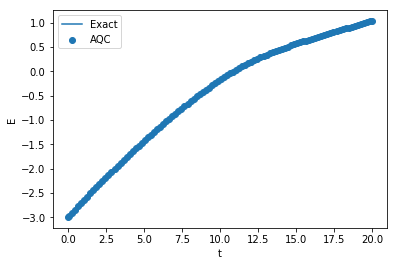

In [11]:
plt.scatter(sol.t, energies, label='AQC')
plt.plot(sol.t, exact_energies, label='Exact')
plt.xlabel('t')
plt.ylabel('E')
plt.legend()
plt.show()